# Alunos

- André Dorte dos Santos
- Luiz Massao Miyazaki

# Tarefa 3

Esse notebook serve como base para o desenvolvimento da tarefa 3, e deve ser submetido após a conclusão das atividades propostas.

Neste trabalho, iremos utilizar uma Rede Generativa Adversarial (GAN) para gerar dígitos de casas do *dataset* SVHN (*Street View House Numbers*). GANs são formadas por duas redes (discriminador e gerador) que são treinadas simultaneamente, sem compartilhamento de pesos. O gerador é responsável por aprender a transformar um ruído aleatório em uma imagem do *dataset* de interesse, enquanto o discriminador é responsável por classificar as imagens em reais e sintéticas (geradas).

Abaixo, incluímos alguns imports, e mostramos uma maneira de processar o arquivo `train_32x32.mat` (pode ser baixado [aqui](http://ufldl.stanford.edu/housenumbers/train_32x32.mat)) que contém as imagens do dataset [SVHN](http://ufldl.stanford.edu/housenumbers/).

Sugerimos que o código da prática 8 seja estudado, e o mesmo **pode** servir de base para este trabalho, já que o procedimento de treino da GAN não muda.

## Depois de cada atividade, inclua uma breve análise do que foi feito e dos resultados!

# Imports
Vamos importar as dependências necessárias!

In [ ]:
from __future__ import print_function, division

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import sys
import matplotlib.pyplot as plt
import numpy as np

from scipy.io import loadmat

In [ ]:
# Conecta ao google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Carregue o dataset SVHN

Os dados são fornecidos em um arquivo .mat, que armazena um dicionário.

Para acessar os dados armazenados, utilizamos a função `loadmat` do pacote `scipy`.  Para acessar as imagens, acessamos o campo `['X']` desse dicionário. Um exemplo é mostrado abaixo:

Obs.: Lembre-se que para o Keras usando Tensorflow como backend, a dimensão dos canais deve ser a última do seu vetor.

(73257, 32, 32, 3)


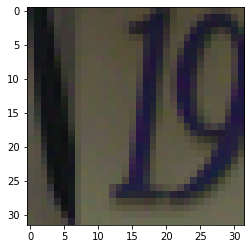

In [ ]:
# Carrega o dataset
X_train = loadmat('gdrive/My Drive/SVHN_Dataset/train_32x32.mat')['X']

X_train = np.moveaxis(X_train, -1, 0)
print(X_train.shape)

plt.imshow(X_train[0])

# Vanilla GAN com o SVHN
A rede mostrada na prática 8 gerava os dígitos do MNIST utilizando camadas densas. Apesar de também conter dígitos, o SVHN possui imagens maiores (32x32), e 3 canais (RGB). Essas diferenças fazem com que a rede precise ser levemente adaptada para poder trabalhar com o novo dataset e gerar novas amostras.

Portanto, altere o código da prática 8 para gerar dados do dataset SVHN com as camadas Densas da 'Vanilla' GAN, e mostre os resultados. A 'Vanilla' GAN conseguiu gerar as imagens do (mais complexo) dataset SVHN?


**Funções que definem a arquitetura e montam o gerador e discriminador**

In [ ]:
def build_generator(latent_dim, img_shape):
  model = Sequential()

  model.add(layers.Dense(256, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(1024))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
  model.add(layers.Reshape(img_shape))

  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_discriminator(img_shape):

  model = Sequential()

  model.add(layers.Flatten(input_shape=img_shape))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(1, activation='sigmoid'))

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

**Função que exibe alguns exemplos de imagens**

In [ ]:
def sample_images(iter, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Re-escale as imagens para [0, 1] para plotar.
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

**Constrói e compila o gerador, discriminador e faz um modelo combinado entre els para treinar o discriminador**

In [ ]:
img_shape = [32, 32, 1, 3]
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Constrói e compila o discriminador
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


# Constrói o gerador
generator = build_generator(latent_dim, img_shape)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim,))
img = generator(z)

# Para o modelo combinado, treinamos apenas o gerador
discriminator.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = discriminator(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
batch_size=64

# Re-escale de -1 a 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

# Ground truth para treinamento. Reais -> 1; Sintéticas (falsas) -> 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [ ]:
iterations=50000
sample_interval=500

In [ ]:
for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth).
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)
  if d_loss[1] > 0.80:
    # print(iter)
    for i in range(5):
      g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator)



A principal mudança que fizemos no exemplo da aula 8 é a img_shape, que foi mudada para (32, 32, 1, 3), pois as imagens são um pouco maiores e elas tem cores.

Abaixo estão alguns exemplos da última iteração, onde alguns números começam a aparecer, mas a qualidade ainda é baixa.

Olhando os resultados vemos que vários números (principalmente o 3, 6 e 8) começaram a ficar claros.

Um detalhe que cabe ressaltar é que há um ruído de pixels espalhados pela imagem.

Alguns exemplos negativos gerados que chamam muita atenção são as imagens quase totalmente brancos e as quase totalmente pretos. Levantamos algumas hipóteses, como que talvez ele tenha aprendido com a parte vazia das imagens, haja exemplos vazios ou são ruídos que entraram em possibilidades que aprenderam pouco, porém não conseguimos confirmá-las.

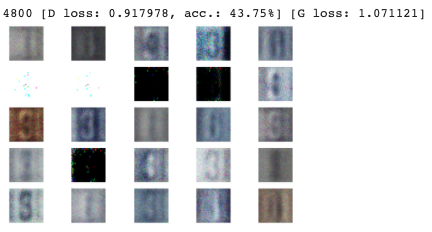

# Arquitetura DCGAN

Defina aqui a arquitetura do gerador e discriminador da DCGAN seguindo o modelo segundo a imagem abaixo:

<img src='https://i.imgur.com/eU2XOxS.png' />

Vamos utilizá-la para gerar os dígitos do SVHN.

In [ ]:
def build_dcgan_generator(latent_dim):

  model = Sequential()

  # Adicione as camadas aqui!
  model.add(layers.Input(shape=latent_dim))
  model.add(layers.Dense(128 * 8 * 8, activation='relu'))
  model.add(layers.Reshape((8, 8, 128)))
  model.add(layers.UpSampling2D())
  model.add(layers.Conv2D(128, 3, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.ReLU())
  model.add(layers.UpSampling2D())
  model.add(layers.Conv2D(64, 3, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.ReLU())
  model.add(layers.Conv2D(3, 3, strides=1, padding='same', activation='tanh'))
  model.add(layers.Reshape(img_shape))

  model.summary()

  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_dcgan_discriminator(img_shape):

  model = Sequential()

  model.add(layers.Reshape((32, 32, 3), input_shape=img_shape))
  model.add(layers.Conv2D(32, 3, strides=2, padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(64, 3, strides=2, padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(128, 3, strides=2, padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(256, 3, strides=1, padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  model.summary()

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

# Treine a DCGAN!

Dica: Estude o código mostrado em sala na prática 8, e adapte-o para treinar a DCGAN.

In [ ]:
# Constrói e compila o discriminador
dcgan_discriminator = build_dcgan_discriminator(img_shape)
dcgan_discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# Constrói o gerador
dcgan_generator = build_dcgan_generator(latent_dim)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim,))
img = dcgan_generator(z)

# Para o modelo combinado, treinamos apenas o gerador
dcgan_discriminator.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = dcgan_discriminator(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)         

In [ ]:
for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = dcgan_generator.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = dcgan_discriminator.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = dcgan_discriminator.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth).
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)
  if d_loss[1] > 0.80:
    # print(iter)
    for i in range(5):
      g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, dcgan_generator)


As imagens geradas pela DCGAN possuem menos pixels de ruído, mas alguns ruídos se apresentam como textura ou manchas, atrapalhando a visualização do número na imagem.

Mesmo assim há alguns números que dá para reconhecer, como o 1 e 3.

Abaixo estão as imagens da última iteração:

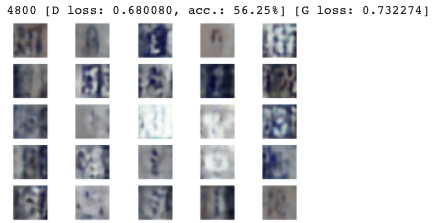

# Escreva aqui um parágrafo com suas conclusões gerais e análises sobre o experimento proposto.




**Imagens geradas pela Vanilla GAN**

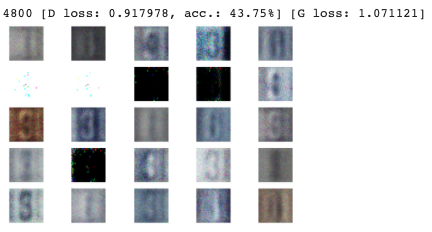

**Imagens gerad as pela DCGAN**

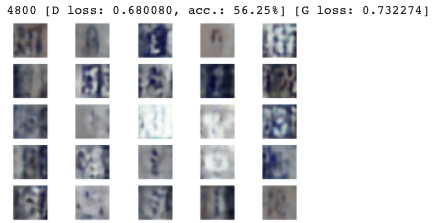

A Vanilla GAN gerou imagens com muito ruído de pixels por muitas iterações, enquanto a DCGAN em bem menos iterações começou a convergir para imagens mais complexas e sem os pixels-ruído, porém com algumas texturas e manchas que tornam difícil o reconhecimento de vários dos números.

Não tivemos tempo para fazer execuções com mais iterações, que talvez levasse a um melhor resultado das DCGANS, mesmo assim conseguimos entender melhor o funcionamento das camadas, como o gerador e discriminador interagem e o quão poderosa essa técnica é.